# Importing libs

In [1]:
import pandas as pd
import sklearn 
import joblib
import  matplotlib.pyplot  as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from feature_engine.datetime import DatetimeFeatures

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from sklearn.model_selection import  learning_curve
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


# 2. Display Settings

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
sklearn.set_config(transform_output='default')

# 3. Getting the Data

In [4]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

### 3.1 Split the data

In [5]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)


In [6]:
X_train,y_train = split_data(train_df)

In [7]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [8]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [9]:
X_test,y_test = split_data(test_df)
X_val,y_val = split_data(val_df)

In [10]:
print(X_val.shape,y_val.shape)

(160, 9) (160,)


In [11]:
print(X_test.shape,y_test.shape)

(200, 9) (200,)


### 3.2 Meta-info

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4 Data Preporcessing

In [13]:
num_cols = ["duration","total_stops"]
dt_cols = ["date_of_journey","dep_time","arrival_time"]

cat_cols = [col for col in X_train.columns if(col not in dt_cols) and (col not in num_cols)]

In [14]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class DatetimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_extract=None, format="mixed", prefix=None):
        self.features_to_extract = features_to_extract
        self.format = format
        self.prefix = prefix  # Add prefix parameter
    
    def __sklearn_tags__(self):
        return {
            'allow_nan': True,
            'requires_y': False,
            'requires_fit': False,
            'preserves_dtype': True,
            'X_types': ['2darray', 'string']
        }
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = pd.DataFrame(X) if isinstance(X, np.ndarray) else X.copy()
        
        # Handle both date and time formats
        if 'hour' in self.features_to_extract or 'minute' in self.features_to_extract:
            # For time columns
            X_datetime = pd.to_datetime(X.iloc[:, 0].map(lambda x: f'2000-01-01 {x}'))
        else:
            # For date column
            X_datetime = pd.to_datetime(X.iloc[:, 0])
        
        features = pd.DataFrame()
        
        feature_extractors = {
            'year': lambda x: x.dt.year,
            'month': lambda x: x.dt.month,
            'day_of_month': lambda x: x.dt.day,
            'day_of_week': lambda x: x.dt.dayofweek,
            'week': lambda x: x.dt.isocalendar().week,
            'hour': lambda x: x.dt.hour,
            'minute': lambda x: x.dt.minute
        }
        
        for feature in self.features_to_extract:
            if feature in feature_extractors:
                features[feature] = feature_extractors[feature](X_datetime)
                
        return features.values
        
    def get_feature_names_out(self, input_features=None):
        if self.prefix:
            return [f"{self.prefix}_{feature}" for feature in self.features_to_extract]
        return [f"{feature}" for feature in self.features_to_extract]




In [16]:
import sys
setattr(sys.modules[__name__], 'DatetimeFeatures', DatetimeFeatures)

In [17]:
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

# Update the pipeline definitions
doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], prefix="doj")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("split", ColumnTransformer([
        ("dep_time", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], prefix="dep")),
            ("scaler", StandardScaler())
        ]), ["dep_time"]),
        ("arrival_time", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], prefix="arrival")),
            ("scaler", StandardScaler())
        ]), ["arrival_time"])
    ]))
])

In [18]:
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"])
])

In [19]:
preprocessor.fit_transform(X_train)


array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]], shape=(640, 33))

# 5. Model selection

In [20]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10, random_state=42)
}


In [21]:
data = pd.concat([train_df, val_df], axis=0)
data

x_data ,y_data = split_data(data)
print(x_data.shape, y_data.shape)

(800, 9) (800,)


In [22]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )

    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha=0.5
    )

def plot_learning_curves(name, algorithm, figsize=(12, 4)):
    model = Pipeline(steps=[
        ("pre", preprocessor),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=x_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=-1,
        random_state=42
    )
    
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize=figsize)

    # training curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )

    # test curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)
    ax.legend(loc="lower right")
    plt.show()


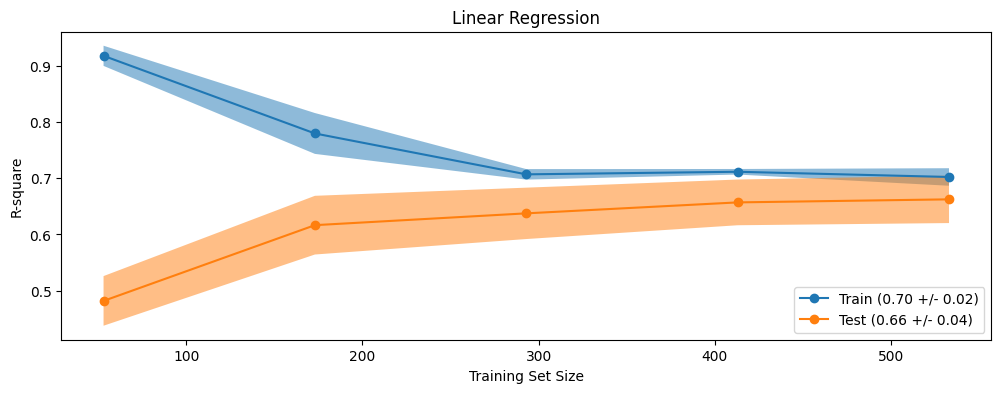

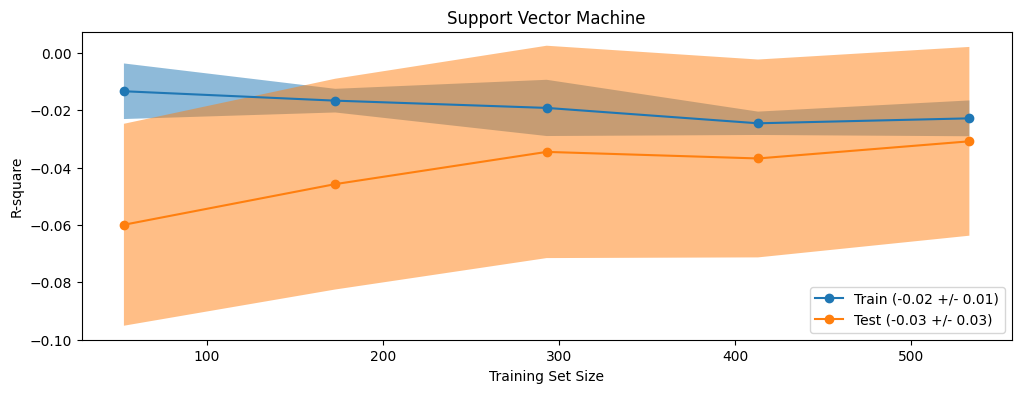

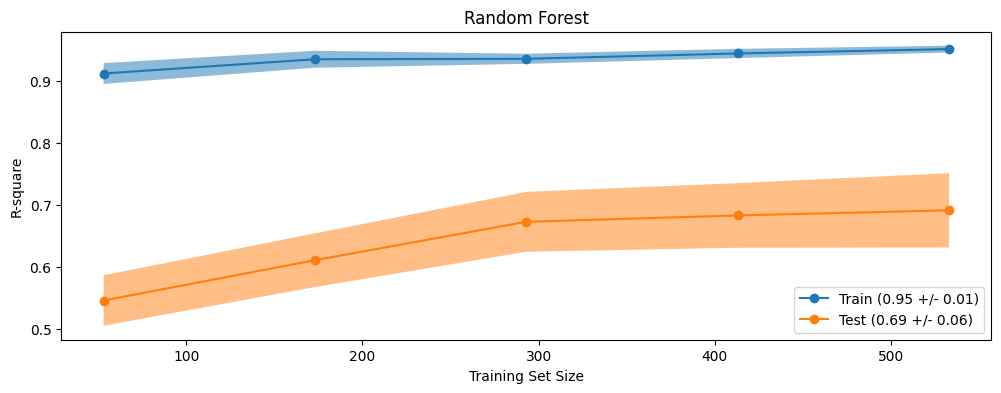

In [23]:
for name,alg in algorithms.items():
    plot_learning_curves(name,alg)

In [24]:
from xgboost import XGBRegressor
import numpy as np

# First apply preprocessing
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Then train XGBoost separately
xgb = XGBRegressor(n_estimators=10, random_state=42)
xgb.fit(X_train_transformed, y_train)

# Get predictions and calculate R2 score
predictions = xgb.predict(X_test_transformed)
score = np.corrcoef(predictions, y_test)[0,1]**2
print("XGBoost R2 Score:", score)

XGBoost R2 Score: 0.6935880314594172


## 6. Model Training

In [25]:
model = Pipeline(steps=[
    ("pre", preprocessor),
    ("rf", RandomForestRegressor(n_estimators=10)),
])

In [26]:
model.fit(x_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                                                      prefix='dep')),
                                                                                                                    ('scaler',
                                                                                                                     StandardScaler())]),
                                                                                                    ['dep_time']),
                                                                                                   ('arrival_time',
                                                                                                    Pipeline(steps=[('imputer',
                                                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                                                    ('extractor',
                                                                                                                     DatetimeFeatures(features_to_extract=['hour',
                                                                                                                                                           'minute'],
                                                                                                                                      prefix='arrival')),
                                                                                                                    ('scaler',
                                                                                                                     StandardScaler())]),
                                                                                                    ['arrival_time'])]))]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7.Model evaluation

In [27]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [28]:
print(f"R2 Score on train: {evaluate_model(x_data,y_data)}")

R2 Score on train: 0.956634986718569


In [29]:
print(f"R2 Score on train: {evaluate_model(X_test,y_test)}")

R2 Score on train: 0.644959190617501


# 8. Model Persistence 

In [30]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [31]:
saved_model = joblib.load("model.joblib")

In [32]:
y_pred = saved_model.predict(X_test)
r2_score(y_test, y_pred)

0.644959190617501